#Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d '/content'

Archive:  glove.6B.zip
  inflating: /content/glove.6B.50d.txt  
  inflating: /content/glove.6B.100d.txt  
  inflating: /content/glove.6B.200d.txt  
  inflating: /content/glove.6B.300d.txt  


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
%cd '/content'
train=pd.read_csv('train.csv')
msk = np.random.rand(len(train)) < 0.9
train_data = train[msk]
val_data = train[~msk]
test_data=pd.read_csv('test.csv')
#tokenize questions
tokenizer= Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
word_index = tokenizer.word_index
val_sequences=tokenizer.texts_to_sequences(val_data['text'])
train_sequences=tokenizer.texts_to_sequences(train_data['text'])
test_sequences=tokenizer.texts_to_sequences(test_data['text'])

/content


In [ ]:
#embedding using GloVe
embedding_file='glove.6B.300d.txt'
embedding_dim = 300  # Dimensionality of the GloVe word embeddings
vocab_size=400000
embedding_index = {}
with open(embedding_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

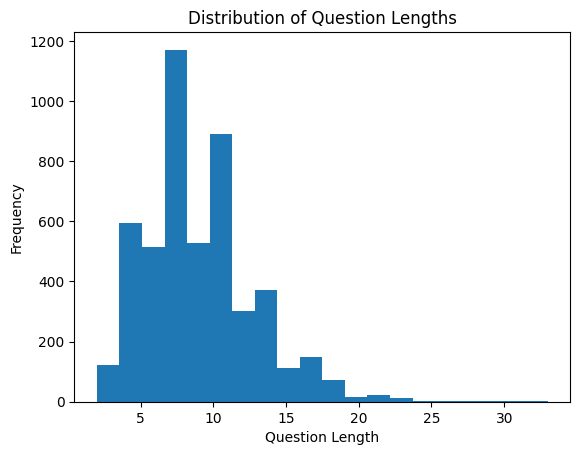

In [ ]:
import matplotlib.pyplot as plt
# Calculate the length of each question
question_lengths = [len(question) for question in train_sequences]
# Plot the distribution
plt.hist(question_lengths, bins=20)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequence_length = 35
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_sequence_length)

In [ ]:
# Convert labels to one-hot encoded format
from tensorflow.keras.utils import to_categorical
train_labels_encoded = to_categorical(train_data['label-coarse'], num_classes=6)
val_labels_encoded = to_categorical(val_data['label-coarse'], num_classes=6)
test_labels_encoded = to_categorical(test_data['label-coarse'], num_classes=6)

#first model(h=25)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding
first_model=Sequential()
first_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length,
                            weights=[embedding_matrix], trainable=False))
# for i in range(10):
#     if i == 0:
first_model.add(LSTM(units=25, input_shape=(max_sequence_length, 1)))
    # elif i==9:
    #     first_model.add(LSTM(units=32))
    # else:
    #     first_model.add(LSTM(units=32, return_sequences=True))
first_model.add(Dense(6,activation='softmax'))
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 300)           120000000 
                                                                 
 lstm (LSTM)                 (None, 25)                32600     
                                                                 
 dense (Dense)               (None, 6)                 156       
                                                                 
Total params: 120,032,756
Trainable params: 32,756
Non-trainable params: 120,000,000
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow import math
def scheduler(epoch, learning_rate):
  if epoch%10==0:
      return learning_rate/10
  else:
    return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)
earlystop=EarlyStopping(monitor='val_Accuracy',patience=10,restore_best_weights=True,mode='max')
first_model.compile(optimizer=Adam(learning_rate=0.01),loss=categorical_crossentropy,metrics=['Accuracy'])
hist_25_first=first_model.fit(train_sequences_padded,train_labels_encoded,epochs=100,validation_data=(val_sequences_padded,val_labels_encoded),callbacks=[lr_scheduler,earlystop])

Epoch 1/100
153/153 [==============================] - 10s 15ms/step - loss: 1.3436 - Accuracy: 0.4745 - val_loss: 0.9349 - val_Accuracy: 0.6828 - lr: 1.0000e-03
Epoch 2/100
153/153 [==============================] - 1s 8ms/step - loss: 0.7442 - Accuracy: 0.7491 - val_loss: 0.6869 - val_Accuracy: 0.7563 - lr: 1.0000e-03
Epoch 3/100
153/153 [==============================] - 1s 8ms/step - loss: 0.5638 - Accuracy: 0.8087 - val_loss: 0.5571 - val_Accuracy: 0.7939 - lr: 1.0000e-03
Epoch 4/100
153/153 [==============================] - 1s 8ms/step - loss: 0.4597 - Accuracy: 0.8500 - val_loss: 0.5104 - val_Accuracy: 0.8136 - lr: 1.0000e-03
Epoch 5/100
153/153 [==============================] - 1s 8ms/step - loss: 0.3867 - Accuracy: 0.8711 - val_loss: 0.4937 - val_Accuracy: 0.8280 - lr: 1.0000e-03
Epoch 6/100
153/153 [==============================] - 1s 8ms/step - loss: 0.3304 - Accuracy: 0.8909 - val_loss: 0.4546 - val_Accuracy: 0.8441 - lr: 1.0000e-03
Epoch 7/100
153/153 [=================

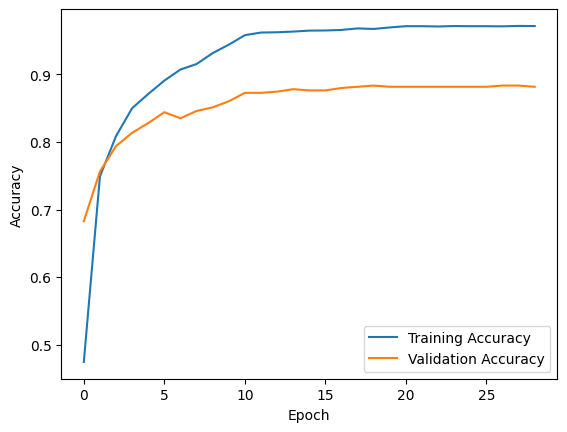

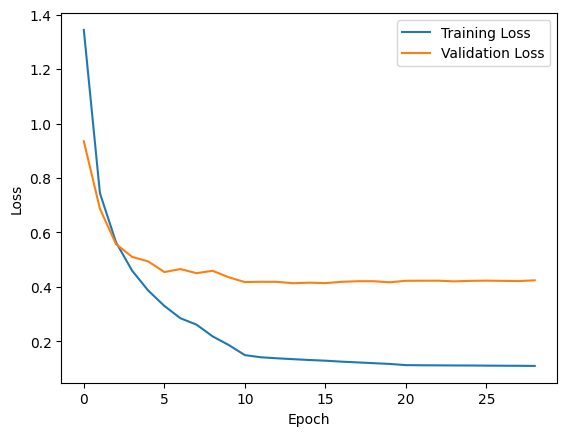

In [ ]:
# Get the accuracy and loss values from the history object
accuracy = hist_25_first.history['Accuracy']
val_accuracy = hist_25_first.history['val_Accuracy']
loss = hist_25_first.history['loss']
val_loss = hist_25_first.history['val_loss']

# Plot the accuracy graph
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss graph
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
first_model.evaluate(test_sequences_padded,test_labels_encoded)

16/16 [==============================] - 0s 4ms/step - loss: 0.3534 - Accuracy: 0.8640


[0.3533550500869751, 0.8640000224113464]

In [ ]:
from sklearn.metrics import classification_report
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(first_model.predict(test_sequences_padded), axis=1)
true_labels=test_data['label-coarse']
print(classification_report(true_labels, predicted_labels))

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.99      0.86       138
           1       0.95      0.61      0.74        94
           2       0.88      0.78      0.82         9
           3       0.91      0.92      0.92        65
           4       0.94      0.87      0.90       113
           5       0.87      0.91      0.89        81

    accuracy                           0.86       500
   macro avg       0.89      0.85      0.86       500
weighted avg       0.88      0.86      0.86       500



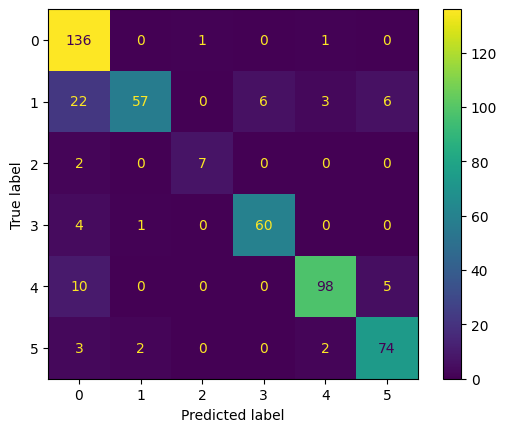

In [ ]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(true_labels,predicted_labels)

#first model(h=100)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding
first_model100=Sequential()
first_model100.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length,
                            weights=[embedding_matrix], trainable=False))
first_model100.add(LSTM(units=100, input_shape=(max_sequence_length, 1)))
first_model100.add(Dense(6,activation='softmax'))
first_model100.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 35, 300)           120000000 
                                                                 
 lstm_5 (LSTM)               (None, 100)               160400    
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 120,161,006
Trainable params: 161,006
Non-trainable params: 120,000,000
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
def scheduler(epoch, learning_rate):
  if epoch%30==0:
      return learning_rate/10
  else:
    return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)
earlystop=EarlyStopping(monitor='val_Accuracy',patience=10,restore_best_weights=True,mode='max')
first_model100.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['Accuracy'])
hist_100_first=first_model100.fit(train_sequences_padded,train_labels_encoded,epochs=100,validation_data=(val_sequences_padded,val_labels_encoded),callbacks=[earlystop,lr_scheduler])

Epoch 1/100
154/154 [==============================] - 24s 84ms/step - loss: 1.0180 - Accuracy: 0.6107 - val_loss: 0.6572 - val_Accuracy: 0.7542 - lr: 1.0000e-03
Epoch 2/100
154/154 [==============================] - 12s 76ms/step - loss: 0.5436 - Accuracy: 0.8110 - val_loss: 0.5720 - val_Accuracy: 0.7948 - lr: 1.0000e-03
Epoch 3/100
154/154 [==============================] - 10s 65ms/step - loss: 0.4200 - Accuracy: 0.8532 - val_loss: 0.5068 - val_Accuracy: 0.8096 - lr: 1.0000e-03
Epoch 4/100
154/154 [==============================] - 20s 129ms/step - loss: 0.3101 - Accuracy: 0.8949 - val_loss: 0.5114 - val_Accuracy: 0.8096 - lr: 1.0000e-03
Epoch 5/100
154/154 [==============================] - 27s 177ms/step - loss: 0.2444 - Accuracy: 0.9153 - val_loss: 0.5042 - val_Accuracy: 0.8207 - lr: 1.0000e-03
Epoch 6/100
154/154 [==============================] - 26s 169ms/step - loss: 0.1865 - Accuracy: 0.9379 - val_loss: 0.4945 - val_Accuracy: 0.8336 - lr: 1.0000e-03
Epoch 7/100
154/154 [====

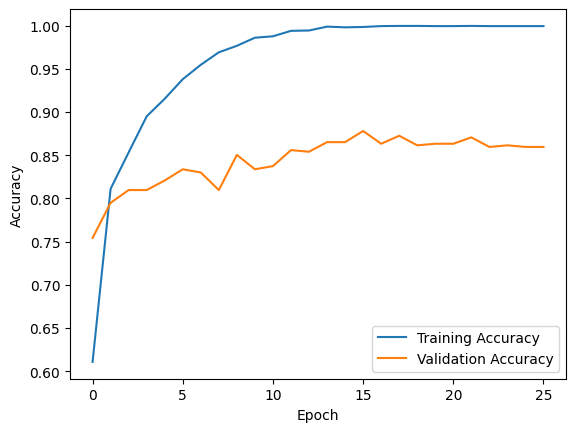

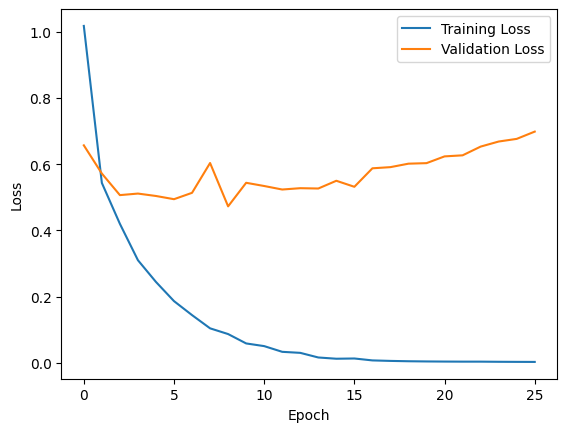

In [ ]:
import matplotlib.pyplot as plt
# Get the accuracy and loss values from the history object
accuracy = hist_100_first.history['Accuracy']
val_accuracy = hist_100_first.history['val_Accuracy']
loss = hist_100_first.history['loss']
val_loss = hist_100_first.history['val_loss']

# Plot the accuracy graph
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss graph
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
first_model100.evaluate(test_sequences_padded,test_labels_encoded)

16/16 [==============================] - 0s 21ms/step - loss: 0.3425 - Accuracy: 0.9060


[0.3425014317035675, 0.906000018119812]

In [ ]:
# Convert predicted probabilities to class labels
from sklearn.metrics import classification_report
predicted_labels = np.argmax(first_model100.predict(test_sequences_padded), axis=1)
true_labels=test_data['label-coarse']
print(classification_report(true_labels, predicted_labels))

16/16 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       138
           1       0.92      0.81      0.86        94
           2       0.88      0.78      0.82         9
           3       0.95      0.95      0.95        65
           4       0.96      0.89      0.93       113
           5       0.89      0.89      0.89        81

    accuracy                           0.91       500
   macro avg       0.91      0.88      0.89       500
weighted avg       0.91      0.91      0.91       500



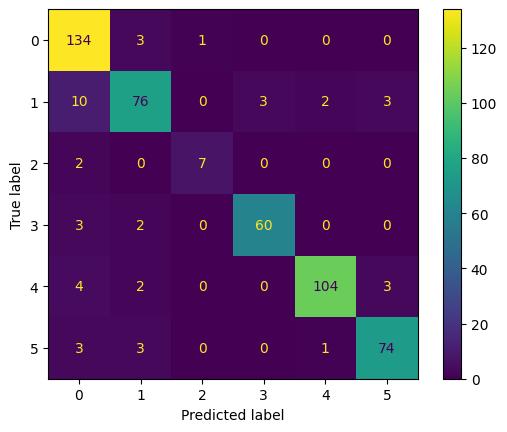

In [ ]:
ConfusionMatrixDisplay.from_predictions(true_labels,predicted_labels)

#second model(h=25)

In [ ]:
train_data['label-fine'].max()

46

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense
# Define the input tensor
inputs = Input(shape=(max_sequence_length,), name='input')

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False)(inputs)

# LSTM layer
lstm_layer = LSTM(units=25, return_sequences=True, return_state=True)
output, hidden_state, cell_state = lstm_layer(x)

# h[t-1] is the hidden state at the previous time step
main_class_pred = Dense(6, activation='softmax', name='coarse')(hidden_state)
sub_class_pred = Dense(47, activation='softmax', name='fine')(output[:, -1, :])

# Create the model
second_model25 = Model(inputs, [main_class_pred, sub_class_pred])
second_model25.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 35)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 35, 300)      120000000   ['input[0][0]']                  
                                                                                                  
 lstm_8 (LSTM)                  [(None, 35, 25),     32600       ['embedding_8[0][0]']            
                                 (None, 25),                                                      
                                 (None, 25)]                                                      
                                                                                            

In [ ]:
fine_train_labels_encoded = to_categorical(train_data['label-fine'], num_classes=47)
fine_val_labels_encoded = to_categorical(val_data['label-fine'], num_classes=47)
fine_test_labels_encoded = to_categorical(test_data['label-fine'], num_classes=47)
max_sequence_length = 35
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_sequence_length,padding='post')
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_sequence_length,padding='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_sequence_length,padding='post')

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
second_model25.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['Accuracy'])
def scheduler(epoch, learning_rate):
  if epoch==10:
      return learning_rate/10
  else:
    return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)
earlystop=EarlyStopping(monitor='val_fine_Accuracy',patience=10,restore_best_weights=True,mode='max',start_from_epoch=10)
hist_25_second=second_model25.fit(train_sequences_padded,[train_labels_encoded,fine_train_labels_encoded],epochs=100,validation_data=(val_sequences_padded,[val_labels_encoded,fine_val_labels_encoded]),callbacks=[earlystop,lr_scheduler])

Epoch 1/100
153/153 [==============================] - 4s 10ms/step - loss: 4.2131 - coarse_loss: 1.3750 - fine_loss: 2.8381 - coarse_Accuracy: 0.4105 - fine_Accuracy: 0.2791 - val_loss: 4.0275 - val_coarse_loss: 1.3732 - val_fine_loss: 2.6543 - val_coarse_Accuracy: 0.4337 - val_fine_Accuracy: 0.3136 - lr: 0.0100
Epoch 2/100
153/153 [==============================] - 1s 6ms/step - loss: 3.5391 - coarse_loss: 1.0898 - fine_loss: 2.4493 - coarse_Accuracy: 0.5509 - fine_Accuracy: 0.3613 - val_loss: 3.2703 - val_coarse_loss: 1.0332 - val_fine_loss: 2.2370 - val_coarse_Accuracy: 0.6111 - val_fine_Accuracy: 0.4265 - lr: 0.0100
Epoch 3/100
153/153 [==============================] - 1s 6ms/step - loss: 2.9736 - coarse_loss: 0.8569 - fine_loss: 2.1167 - coarse_Accuracy: 0.6751 - fine_Accuracy: 0.4420 - val_loss: 2.8015 - val_coarse_loss: 0.8282 - val_fine_loss: 1.9733 - val_coarse_Accuracy: 0.7151 - val_fine_Accuracy: 0.4857 - lr: 0.0100
Epoch 4/100
153/153 [==============================] - 1s

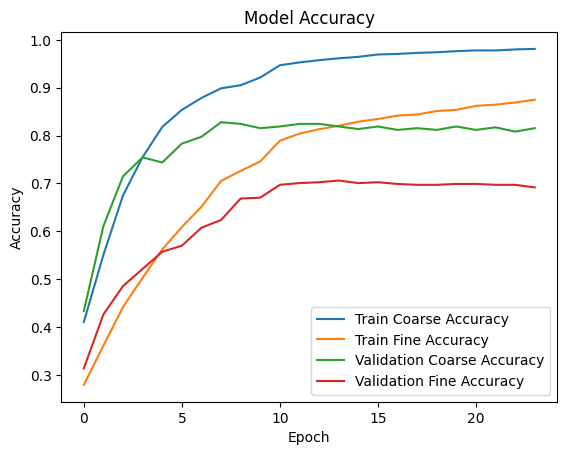

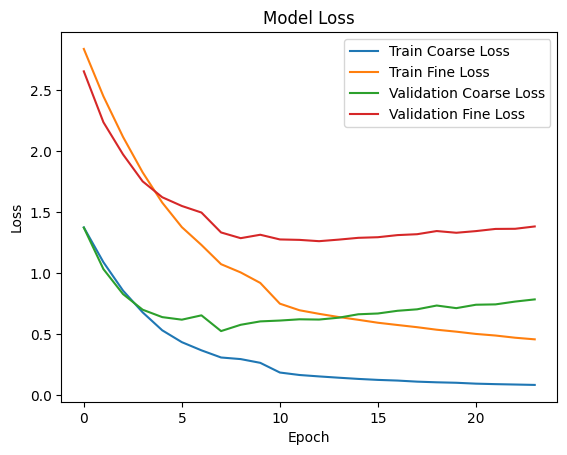

In [ ]:
# Plot accuracy
plt.plot(hist_25_second.history['coarse_Accuracy'])
plt.plot(hist_25_second.history['fine_Accuracy'])
plt.plot(hist_25_second.history['val_coarse_Accuracy'])
plt.plot(hist_25_second.history['val_fine_Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Coarse Accuracy', 'Train Fine Accuracy', 'Validation Coarse Accuracy', 'Validation Fine Accuracy'])
plt.show()

# Plot loss
plt.plot(hist_25_second.history['coarse_loss'])
plt.plot(hist_25_second.history['fine_loss'])
plt.plot(hist_25_second.history['val_coarse_loss'])
plt.plot(hist_25_second.history['val_fine_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Coarse Loss', 'Train Fine Loss', 'Validation Coarse Loss', 'Validation Fine Loss'])
plt.show()

In [ ]:
second_model25.evaluate(test_sequences_padded,[test_labels_encoded,fine_test_labels_encoded])

16/16 [==============================] - 0s 4ms/step - loss: 1.8837 - coarse_loss: 0.4823 - fine_loss: 1.4014 - coarse_Accuracy: 0.8700 - fine_Accuracy: 0.6920


[1.8836685419082642,
 0.48227396607398987,
 1.4013947248458862,
 0.8700000047683716,
 0.6919999718666077]

In [ ]:
from sklearn.metrics import classification_report
coarse_pred, fine_pred = second_model25.predict(test_sequences_padded)
coarse_true = test_data['label-coarse']
fine_true = test_data['label-fine']

# Convert the predicted labels to class indices
coarse_pred_indices = np.argmax(coarse_pred, axis=1)
fine_pred_indices = np.argmax(fine_pred, axis=1)

# Generate classification report for coarse predictions
coarse_report = classification_report(coarse_true, coarse_pred_indices)
print("Coarse Classification Report:")
print(coarse_report)

# Generate classification report for fine predictions
fine_report = classification_report(fine_true, fine_pred_indices)
print("Fine Classification Report:")
print(fine_report)

16/16 [==============================] - 0s 2ms/step
Coarse Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       138
           1       0.83      0.71      0.77        94
           2       0.62      0.56      0.59         9
           3       0.91      0.94      0.92        65
           4       0.96      0.88      0.92       113
           5       0.85      0.89      0.87        81

    accuracy                           0.87       500
   macro avg       0.83      0.82      0.83       500
weighted avg       0.87      0.87      0.87       500

Fine Classification Report:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.00      0.00      0.00         0
           2       0.83      0.31      0.45        16
           3       0.45      0.62      0.53         8
           4       0.90      0.95      0.92        55
           5       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Text(0.5, 1.0, 'coarse_cm')

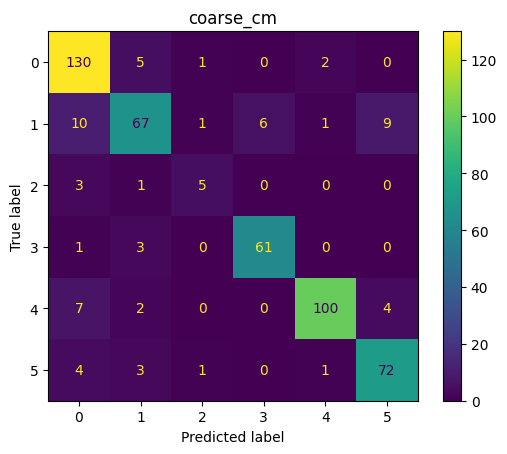

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(coarse_true ,coarse_pred_indices )
plt.title('coarse_cm')

#second_model(h=100)

In [ ]:
from tensorflow.keras.layers import Dense
# Define the input tensor
inputs = Input(shape=(max_sequence_length,), name='input')

# Embedding layer
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False)(inputs)

# LSTM layer
lstm_layer = LSTM(units=100, return_sequences=True, return_state=True,name='second100lstm')
output, hidden_state, cell_state = lstm_layer(x)
# h[t-1] is the hidden state at the previous time step
main_class_pred = Dense(6, activation='softmax', name='coarse')(hidden_state)
sub_class_pred = Dense(47, activation='softmax', name='fine')(output[:, -1, :])

# Create the model
second_model100 = Model(inputs, [main_class_pred, sub_class_pred])
second_model100.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 35)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 35, 300)      120000000   ['input[0][0]']                  
                                                                                                  
 second100lstm (LSTM)           [(None, 35, 100),    160400      ['embedding_9[0][0]']            
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
%cd '/content/drive/MyDrive'
second_model100.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['Accuracy'])
checkpoint = ModelCheckpoint('second100.h5', save_best_only=True)
def scheduler(epoch, learning_rate):
  if epoch%20==0:
      return learning_rate/10
  else:
    return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)
earlystop=EarlyStopping(monitor='val_fine_Accuracy',patience=10,restore_best_weights=True,mode='max',start_from_epoch=10)
hist_100_second=second_model100.fit(train_sequences_padded,[train_labels_encoded,fine_train_labels_encoded],epochs=100,validation_data=(val_sequences_padded,[val_labels_encoded,fine_val_labels_encoded]),callbacks=[earlystop,lr_scheduler,checkpoint])

/content/drive/MyDrive
Epoch 1/100
153/153 [==============================] - 5s 19ms/step - loss: 4.7127 - coarse_loss: 1.6138 - fine_loss: 3.0989 - coarse_Accuracy: 0.2783 - fine_Accuracy: 0.1945 - val_loss: 4.1670 - val_coarse_loss: 1.4127 - val_fine_loss: 2.7543 - val_coarse_Accuracy: 0.4158 - val_fine_Accuracy: 0.3100 - lr: 1.0000e-03
Epoch 2/100
153/153 [==============================] - 3s 17ms/step - loss: 3.8583 - coarse_loss: 1.2502 - fine_loss: 2.6081 - coarse_Accuracy: 0.4906 - fine_Accuracy: 0.3347 - val_loss: 3.3690 - val_coarse_loss: 1.0671 - val_fine_loss: 2.3019 - val_coarse_Accuracy: 0.5932 - val_fine_Accuracy: 0.4516 - lr: 1.0000e-03
Epoch 3/100
153/153 [==============================] - 4s 24ms/step - loss: 2.9763 - coarse_loss: 0.8766 - fine_loss: 2.0998 - coarse_Accuracy: 0.6686 - fine_Accuracy: 0.4497 - val_loss: 2.8145 - val_coarse_loss: 0.8372 - val_fine_loss: 1.9773 - val_coarse_Accuracy: 0.6810 - val_fine_Accuracy: 0.4642 - lr: 1.0000e-03
Epoch 4/100
153/153 

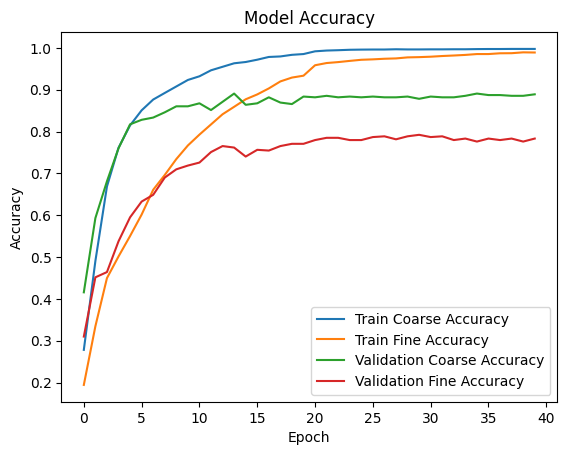

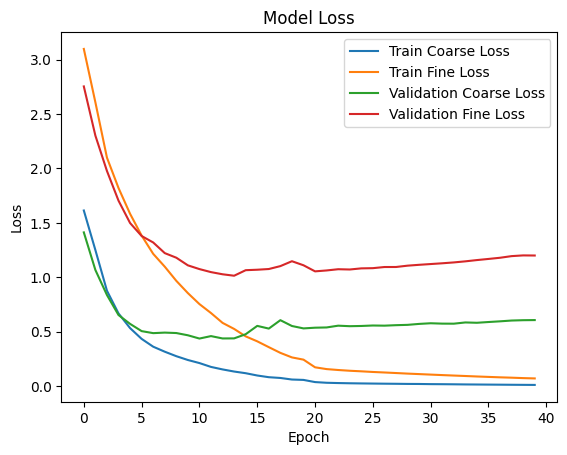

In [ ]:
# Plot accuracy
plt.plot(hist_100_second.history['coarse_Accuracy'])
plt.plot(hist_100_second.history['fine_Accuracy'])
plt.plot(hist_100_second.history['val_coarse_Accuracy'])
plt.plot(hist_100_second.history['val_fine_Accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Coarse Accuracy', 'Train Fine Accuracy', 'Validation Coarse Accuracy', 'Validation Fine Accuracy'])
plt.show()

# Plot loss
plt.plot(hist_100_second.history['coarse_loss'])
plt.plot(hist_100_second.history['fine_loss'])
plt.plot(hist_100_second.history['val_coarse_loss'])
plt.plot(hist_100_second.history['val_fine_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Coarse Loss', 'Train Fine Loss', 'Validation Coarse Loss', 'Validation Fine Loss'])
plt.show()

In [ ]:
second_model100.evaluate(test_sequences_padded,[test_labels_encoded,fine_test_labels_encoded])

16/16 [==============================] - 0s 4ms/step - loss: 1.4538 - coarse_loss: 0.4188 - fine_loss: 1.0350 - coarse_Accuracy: 0.9220 - fine_Accuracy: 0.8080


[1.4537951946258545,
 0.41880062222480774,
 1.03499436378479,
 0.921999990940094,
 0.8080000281333923]

In [ ]:
from sklearn.metrics import classification_report
coarse_pred, fine_pred = second_model100.predict(test_sequences_padded)
coarse_true = test_data['label-coarse']
fine_true = test_data['label-fine']

# Convert the predicted labels to class indices
coarse_pred_indices = np.argmax(coarse_pred, axis=1)
fine_pred_indices = np.argmax(fine_pred, axis=1)

# Generate classification report for coarse predictions
coarse_report = classification_report(coarse_true, coarse_pred_indices)
print("Coarse Classification Report:")
print(coarse_report)

# Generate classification report for fine predictions
fine_report = classification_report(fine_true, fine_pred_indices)
print("Fine Classification Report:")
print(fine_report)

16/16 [==============================] - 0s 2ms/step
Coarse Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       138
           1       0.94      0.81      0.87        94
           2       0.88      0.78      0.82         9
           3       0.95      0.94      0.95        65
           4       0.96      0.92      0.94       113
           5       0.92      0.96      0.94        81

    accuracy                           0.92       500
   macro avg       0.92      0.90      0.91       500
weighted avg       0.92      0.92      0.92       500

Fine Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       0.90      0.56      0.69        16
           3       0.86      0.75      0.80         8
           4       0.96      0.95      0.95        55
           5       0.71      0.83      0.77         6
           6       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'coarse_cm')

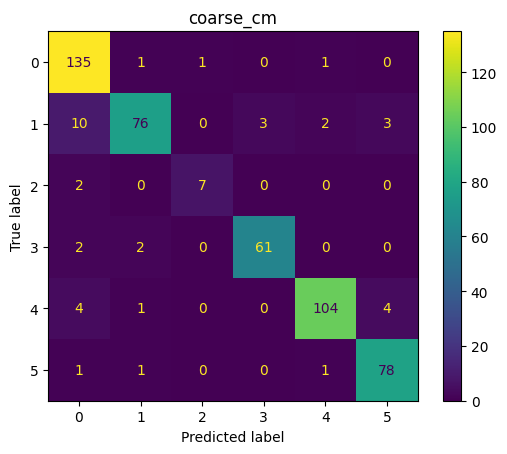

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(coarse_true ,coarse_pred_indices )
plt.title('coarse_cm')

#prototype responder
##preprocess QA







In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%cd '/content'
QA=pd.read_csv('QA_data.csv',encoding='cp1252')
msk = np.random.rand(len(QA)) < 0.9
train_data = QA[msk]
val_data = QA[~msk]
#tokenize questions
tokenizer= Tokenizer()
tokenizer.fit_on_texts(train_data['text'] + train_data['answer'])
train_ques_seq = tokenizer.texts_to_sequences(train_data['text'])
val_ques_seq = tokenizer.texts_to_sequences(val_data['text'])
train_ans_seq = tokenizer.texts_to_sequences(train_data['answer'])
val_ans_seq = tokenizer.texts_to_sequences(val_data['answer'])
word_index=tokenizer.word_index

/content


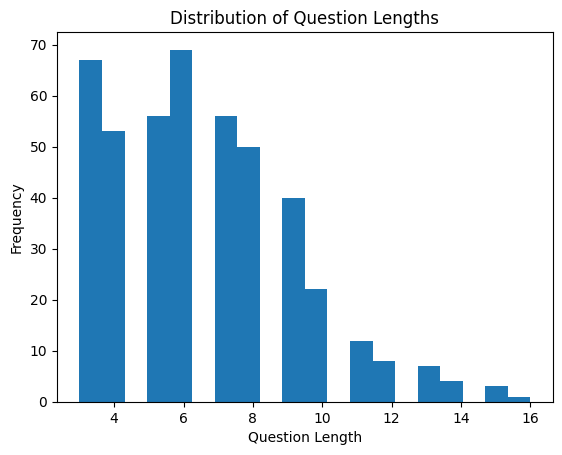

In [ ]:
import matplotlib.pyplot as plt
# Calculate the length of each question
question_lengths = [len(question) for question in train_ques_seq]
# Plot the distribution
plt.hist(question_lengths, bins=20)
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths')
plt.show()

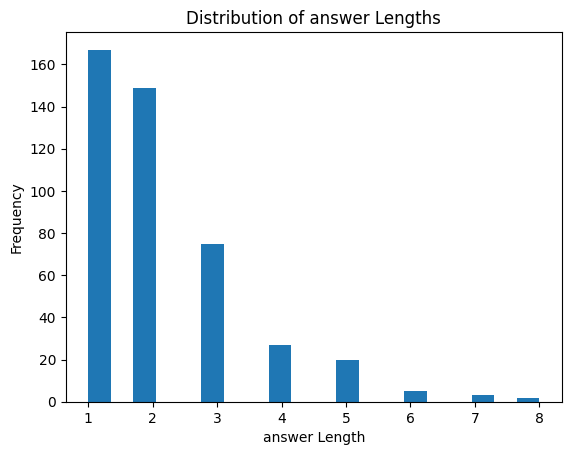

In [ ]:
# Calculate the length of each question
ans_lengths = [len(answer) for answer in train_ans_seq]
# Plot the distribution
plt.hist(ans_lengths, bins=20)
plt.xlabel('answer Length')
plt.ylabel('Frequency')
plt.title('Distribution of answer Lengths')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len_ques=8
max_len_ans=8
train_quest_seq_padded = pad_sequences(train_ques_seq, maxlen=max_len_ques,padding='post')
train_ans_seq_padded = pad_sequences(train_ans_seq, maxlen=max_len_ans,padding='post')
val_quest_seq_padded = pad_sequences(val_ques_seq, maxlen=max_len_ques,padding='post')
val_ans_seq_padded = pad_sequences(val_ans_seq, maxlen=max_len_ans,padding='post')

In [ ]:
from tensorflow.keras.utils import to_categorical
train_ans_seq_padded = np.array(train_ans_seq_padded)
val_ans_seq_padded = np.array(val_ans_seq_padded)

# Concatenate the two arrays
concatenated_array = np.concatenate((train_ans_seq_padded, val_ans_seq_padded))

# Find the number of unique categories
unique_categories = np.unique(concatenated_array)
category_num = len(unique_categories)
# Sort the unique class labels
sorted_classes = np.sort(unique_categories)
# Create a mapping between class labels and consecutive integer indices
class_index_mapping = {class_val: index for index, class_val in enumerate(sorted_classes)}
# Create a vectorized version of the mapping dictionary lookup
vectorized_lookup = np.vectorize(class_index_mapping.get)

# Convert class labels to integer indices
train_ans_seq_indices = vectorized_lookup(train_ans_seq_padded)
val_ans_seq_indices = vectorized_lookup(val_ans_seq_padded)
# Convert integer indices to one-hot encoded vectors
train_ans_seq_encoded = to_categorical(train_ans_seq_indices, num_classes=category_num)
val_ans_seq_encoded = to_categorical(val_ans_seq_indices, num_classes=category_num)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
def masked_categorical_crossentropy(y_true, y_pred):
    # Apply masking to exclude padding elements
    mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(y_true, axis=-1), 0))
    masked_true = tf.boolean_mask(y_true, mask)
    masked_pred = tf.boolean_mask(y_pred, mask)

    # Compute the categorical cross-entropy loss
    loss = tf.keras.losses.categorical_crossentropy(masked_true, masked_pred)
    return loss

In [ ]:
#embedding using GloVe
%cd '/content'
embedding_file='glove.6B.300d.txt'
embedding_dim = 300  # Dimensionality of the GloVe word embeddings
vocab_size=400000
embedding_index = {}
with open(embedding_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/content


In [ ]:
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,TimeDistributed,Bidirectional,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
%cd '/content/drive/MyDrive'
second100=load_model('second100.h5')
lstm_weights=second100.get_layer('second100lstm').get_weights()
HIDDEN_DIM=100
inputs = Input(shape=(max_len_ques, ), dtype='int32')
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len_ques, weights=[embedding_matrix], trainable=False)(inputs)
lstm = LSTM(HIDDEN_DIM, return_state=True,name='lstm_responder')
_, state_h, state_c = lstm(embedding)
bilstm = Bidirectional(LSTM(HIDDEN_DIM, return_sequences=True))
Biout1= bilstm(embedding, initial_state=[state_h, state_c, state_h, state_c])
Biout2=Bidirectional(LSTM(HIDDEN_DIM*2, return_sequences=True))(Biout1)
Biout3=Bidirectional(LSTM(HIDDEN_DIM*2, return_sequences=True))(Biout2)
outputs = TimeDistributed(Dense(category_num, activation='softmax'))(Biout3)
# Add a Reshape layer to reshape the output to (None, 8, 759)
#outputs=Reshape((max_len_ans,category_num))(dense_out)
responder= Model(inputs, outputs) 
responder.get_layer('lstm_responder').set_weights(lstm_weights)  
responder.summary() 


/content/drive/MyDrive
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 8)]          0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 8, 300)       120000000   ['input_12[0][0]']               
                                                                                                  
 lstm_responder (LSTM)          [(None, 100),        160400      ['embedding_11[0][0]']           
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                     

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping
from tensorflow.keras.optimizers import Adam
responder.compile(optimizer=Adam(learning_rate=0.0001), loss=masked_categorical_crossentropy, metrics=['accuracy'])
batch_size = 32
epochs = 100
checkpoint = ModelCheckpoint('responder.h5', save_best_only=True)
def scheduler(epoch, learning_rate):
  if epoch%5==0:
      return learning_rate/10
  else:
    return learning_rate
lr_scheduler = LearningRateScheduler(scheduler)
earlystop=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,mode='min')
history = responder.fit(train_quest_seq_padded, train_ans_seq_encoded,
    validation_data=(val_quest_seq_padded, val_ans_seq_encoded),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint,earlystop]
)

Epoch 1/100
14/14 [==============================] - 38s 2s/step - loss: 6.3552 - accuracy: 0.5656 - val_loss: 5.8490 - val_accuracy: 0.8678
Epoch 2/100
14/14 [==============================] - 15s 1s/step - loss: 5.2062 - accuracy: 0.7307 - val_loss: 3.4292 - val_accuracy: 0.8678
Epoch 3/100
14/14 [==============================] - 23s 2s/step - loss: 2.8669 - accuracy: 0.7307 - val_loss: 1.2668 - val_accuracy: 0.8678
Epoch 4/100
14/14 [==============================] - 26s 2s/step - loss: 2.2551 - accuracy: 0.7307 - val_loss: 1.1572 - val_accuracy: 0.8678
Epoch 5/100
14/14 [==============================] - 10s 744ms/step - loss: 2.1067 - accuracy: 0.7307 - val_loss: 1.1959 - val_accuracy: 0.8678
Epoch 6/100
14/14 [==============================] - 12s 878ms/step - loss: 2.0430 - accuracy: 0.7307 - val_loss: 1.2198 - val_accuracy: 0.8678
Epoch 7/100
14/14 [==============================] - 13s 981ms/step - loss: 2.0240 - accuracy: 0.7307 - val_loss: 1.2188 - val_accuracy: 0.8678
Epoc

In [ ]:
# from tensorflow.keras.models import load_model
# %cd '/content/drive/MyDrive'
# responder=load_model('responder.h5')
question = 'When Gandhi was assassinated?'
question_encoded = tokenizer.texts_to_sequences([question])
question_padded = pad_sequences(question_encoded, maxlen=max_len_ques, padding='post')
output = responder.predict(question_padded)

1/1 [==============================] - 0s 408ms/step


In [ ]:
predicted_indices=np.argmax(output, axis=2)
index_class_mapping = {index: class_val for class_val, index in class_index_mapping.items()}
predicted_labels = np.vectorize(index_class_mapping.get)(predicted_indices)